# 1. Business Problem
## 1.1 Problem Context
Our client is an online retailer based in the UK. They sell all-occasion gifts, and many of their customers are wholesalers.
* Most of their customers are from the UK, but they have a small percent of customers from other countries.
* They want to create groups of these international customers based on their previous purchase patterns.
* Their goal is to provide more tailored services and improve the way they market to these international customers.

## 1.2 Problems with current approach
Currently, the retailer simply groups their international customers by country. As you'll see in the project, this is quite inefficient because:
* There's a large number of countries (which kind of defeats the purpose of creating groups).
* Some countries have very few customers.
* This approach treats large and small customers the same, regardless of their purchase patterns.

## 1.3 Problem Statement
The retailer has hired us to help them create customer clusters, a.k.a **"customer segments"** through a data-driven approach.
* They've provided us a dataset of past purchase data at the transaction level.
* Our task is to build a clustering model using that dataset.
* Our clustering model should factor in both aggregate sales patterns and specific items purchased.

## 1.4 Business Objectives and constraints

# 2. Machine Learning Problem
## 2.1 Data Overview
For this project:
* The dataset has 35116 observations for previous international transactions.
* The observations span 37 different countries.
* **Note:** There is no target variable.

We have the following features:

Invoice information
* 'InvoiceNo' – Unique ID for invoice
* 'InvoiceDate' – Invoice date

Item information
* 'StockCode' – Unique ID for item
* 'Description' – Text description for item
* 'Quantity' – Units per pack for item
* 'UnitPrice' – Price per unit in GBP

Customer information
* 'CustomerID' – Unique ID for customer
* 'Country' – Country of customer

## 2.2 Mapping Buisness problem to ML problem
### 2.2.1 Type of ML Problem
It is an unsupervised learning task, where given the features about each transaction, we need to segment the customers based on their buying patterns.
* It is importnat to note that the given data is transaction-level while the clusters (or segmenst) we need to create are customer-level.

# 3. Exploratory Data Analysis
Import the libraries

In [1]:
# NumPy for numerical computing
import numpy as np

# Pandas for DataFrames
import pandas as pd
pd.set_option('display.max_columns', 100)

# Matplotlib for visualization
from matplotlib import pyplot as plt
# display plots in the notebook
%matplotlib inline 

# Seaborn for easier visualization
import seaborn as sns

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# StandardScaler from Scikit-Learn
from sklearn.preprocessing import StandardScaler

# PCA from Scikit-Learn
from sklearn.decomposition import PCA

# Scikit-Learn's KMeans algorithm
from sklearn.cluster import KMeans

# Adjusted Rand index
from sklearn.metrics import adjusted_rand_score

## 3.1 Load the dataset

In [3]:
df=pd.read_csv("Files/int_online_tx.csv")

Since the given data is in transaction level we first visualize it and then convert it into customer level.

In [4]:
df.shape

(35116, 8)

In [7]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France
5,536370,10002,INFLATABLE POLITICAL GLOBE,48,12/1/10 8:45,0.85,12583.0,France
6,536370,21791,VINTAGE HEADS AND TAILS CARD GAME,24,12/1/10 8:45,1.25,12583.0,France
7,536370,21035,SET/2 RED RETROSPOT TEA TOWELS,18,12/1/10 8:45,2.95,12583.0,France
8,536370,22326,ROUND SNACK BOXES SET OF4 WOODLAND,24,12/1/10 8:45,2.95,12583.0,France
9,536370,22629,SPACEBOY LUNCH BOX,24,12/1/10 8:45,1.95,12583.0,France


* We can observe that each unique invoice no represent a bill generated by a customer
* And also a customer can have more than one bill since he/she can visit a store multiple times

In [10]:
df["InvoiceNo"].nunique()

1591

Hence there are 1591 invoice bills generated

Display the distribution of transactions by country.

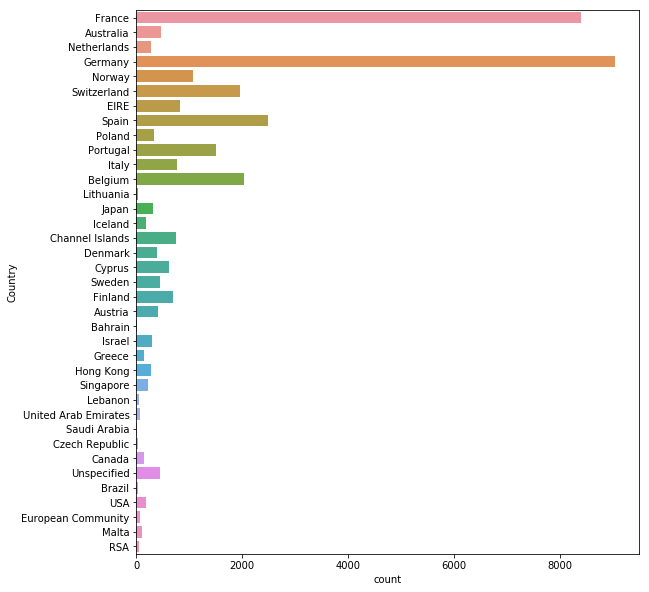

In [16]:

plt.figure(figsize=(9,10))
sns.countplot(y="Country",data=df)

* We can observe that there are many sparse classes.
* Such as countries like Saudi Arabia,Czech Republic etc have very few data points.
* But Note that the data we have is of transaction level hence actual customer count in these areas is much less


# 4. Transaction-level Cleaning

* Before we aggregate the transaction level data into customer level , we need to take care of missing values.

In [17]:
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description       0
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID     1418
Country           0
dtype: int64

'CustomerID' has missing observations
* Should we **label them as missing** (as for categorical features) or should we **flag and fill** them (as for numeric features)?
* We should do neither. Instead, we simply need to drop transactions with missing CustomerID.
* Think back to the project scope: We are trying to cluster customers in order to provide more tailored service!
* That means transactions with missing 'CustomerID' are actually pointless to keep.
* In other words, they should be considered "unwanted observations" instead of "missing data!".

Drop observations with missing customer ID's.

In [18]:
df = df[df.CustomerID.notnull()]

In [19]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,12/1/10 8:45,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,12/1/10 8:45,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,12/1/10 8:45,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,12/1/10 8:45,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,12/1/10 8:45,0.65,12583.0,France


* Now we can observe that we are given UnitPrice for each product and the number of products bought  , we can form a new feature called as total price  using these featires

In [24]:

df['Sales'] = df.Quantity * df.UnitPrice


In [25]:
df.Sales.head()

0    90.0
1    90.0
2    45.0
3    10.2
4    15.6
Name: Sales, dtype: float64

Before moving on, save your cleaned transaction-level data as **cleaned_transactions.csv.**

In [26]:
df.to_csv('Files/cleaned_transactions.csv', index=None)

# 5. Customer-level feature engineering
Now that we have a cleaned transaction-level dataset, it's time to aggregate up to the customer level, which we'll feed into our machine learning algorithms later.

We want 1 customer per row, and we want the features to represent information such as:
* Number of unique purchases by the customer
* Average cart value for the customer
* Total sales for the customer
* Etc.

To do so, we'll use two tools seen already:
* groupby() to roll up by customer.
* agg() to engineer aggregated features.

Aggegrate invoice data by customer. We'll engineer 1 feature:
* 'total_transactions' - the total number of unique transactions for each customer.

In [27]:
invoice_data = df.groupby('CustomerID').InvoiceNo.agg({ 'total_transactions' : 'nunique' })


In [28]:
invoice_data.head()

,total_transactions
CustomerID,
12347.0,7
12348.0,4
12349.0,1
12350.0,1
12352.0,8


Next, using the same technique, aggregate product data by customer. Engineer 2 features:
* 'total_products' - the total number of products purchased by each customer (not the unit Quantity within each product!).
* 'total_unique_products' - the number of unique products purchased by each customer.

In [29]:
product_data = df.groupby('CustomerID').StockCode.agg( { 'total_products' : 'count', 
                                                     'total_unique_products' : 'nunique' } )


In [31]:
product_data.head()

,total_products,total_unique_products
CustomerID,,
12347.0,182,103
12348.0,31,22
12349.0,73,73
12350.0,17,17
12352.0,85,59


Finally, aggregate sales data by customer. Engineer 2 features:
* 'total_sales' - the total sales for each customer.
* 'avg_product_value' - the average value of the products purchased by the customer (not the UnitPrice!).

In [32]:
sales_data = df.groupby('CustomerID').Sales.agg( { 'total_sales' : 'sum', 
                                                  'avg_product_value' : 'mean' } )
sales_data.head()


,total_sales,avg_product_value
CustomerID,,
12347.0,4310.00,23.681319
12348.0,1797.24,57.975484
12349.0,1757.55,24.076027
12350.0,334.40,19.670588
12352.0,2506.04,29.482824


# 6. Intermediary levels
You won't always be able to easily roll up to customer-level directly. Sometimes, it will be easier to create intermediary levels first.

For example, let's say we wanted to calculate the average cart value for each customer.
* 'avg_product_value' isn't the same thing because it doesn't first group products that were purchased within the same "cart" (i.e. invoice).

Therefore, let's first aggregate cart data at the "cart-level."
* We'll group by 'CustomerID' AND by 'InvoiceID'. Remember, we're treating each invoice as a "cart."
* Then, we'll calculate 'cart_value' by taking the sum of the Sales column. This is the total sales by invoice (i.e. cart).
* Finally, we'll call .reset_index() to turn CustomerID and InvoiceID back into regular columns so we can perform another aggregation.

In [33]:
# Aggregate cart-level data (i.e. invoice-level)
cart_data = df.groupby(['CustomerID' , 'InvoiceNo']).Sales.agg( { 'cart_value' : 'sum' })

# Display cart data for first 20 CARTS
cart_data.head(20)

cart_value
CustomerID InvoiceNo            
12347.0    537626         711.79
           542237         475.39
           549222         636.25
           556201         382.52
           562032         584.91
           573511        1294.32
           581180         224.82
12348.0    539318         892.80
           541998         227.44
           548955         367.00
           568172         310.00
12349.0    577609        1757.55
12350.0    543037         334.40
12352.0    544156         296.50
           545323         144.35
           545332         840.30
           546869         120.33
           547390         160.33
           567505         366.25
           568699         266.25

In [34]:
# Reset index
cart_data.reset_index(inplace=True)

# Display cart data for first 10 CARTS
cart_data.head(10)

,CustomerID,InvoiceNo,cart_value
0,12347.0,537626,711.79
1,12347.0,542237,475.39
2,12347.0,549222,636.25
3,12347.0,556201,382.52
4,12347.0,562032,584.91
5,12347.0,573511,1294.32
6,12347.0,581180,224.82
7,12348.0,539318,892.80
8,12348.0,541998,227.44
9,12348.0,548955,367.00


Now we have the value of cart each time a customer had visited a shop now lets engineer features like min cart value,max cart value,average cart value


In [35]:
# Aggregate cart data (at customer-level)
agg_cart_data = cart_data.groupby('CustomerID').cart_value.agg( { 'avg_cart_value' : 'mean', 
                                                                 'min_cart_value' : 'min',
                                                                 'max_cart_value' : 'max'})

# Display cart data for first 5 CUSTOMERS
agg_cart_data.head()

,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,
12347.0,615.714286,224.82,1294.32
12348.0,449.310000,227.44,892.80
12349.0,1757.550000,1757.55,1757.55
12350.0,334.400000,334.40,334.40
12352.0,313.255000,120.33,840.30


# 7. Joining various customer level dataframes
We have multiple dataframes that each contain customer-level features:
* invoice_data
* product_data
* sales_data
* agg_cart_data

Let's join the various customer-level datasets together with the .join() function.
* Just pick one of the customer-level dataframes and join it to a list of the others.
* By default, it will join the dataframes on their index... In this case, it will join by CustomerID, which is exactly what we want.
* You can read more about the .join() function in the official documentation.

In [36]:
# Join together customer-level data
customer_df = invoice_data.join([product_data, sales_data, agg_cart_data])

# Display customer-level data for first 5 customers
customer_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value
CustomerID,,,,,,,,
12347.0,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32
12348.0,4,31,22,1797.24,57.975484,449.310000,227.44,892.80
12349.0,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55
12350.0,1,17,17,334.40,19.670588,334.400000,334.40,334.40
12352.0,8,85,59,2506.04,29.482824,313.255000,120.33,840.30


Finally, let's save customer_df as our **analytical base table** to use later.

**Very Important:** We will not set index=None because we want to keep the CustomerID's as the index (this will be important and we'll see later).

In [38]:
# Save analytical base table
customer_df.to_csv('Files/analytical_base_table.csv')

# 8. Curse of Dimensionality.
Let's import the cleaned dataset (not the analytical base table) that we saved in previously.

In [39]:
# Read cleaned_transactions.csv
df = pd.read_csv('Files/cleaned_transactions.csv')

## 8.1 So what is "The Curse of Dimensionality?"

"dimensionality" refers to the number of features in your dataset. The basic idea is that as the number of features increases, you'll need more and more observations to build any sort of meaningful model, especially for clustering.

Because cluster models are based on the "distance" between two observations, and distance is calculated by taking the differences between feature values, every observation will seem "far away" from each other if the number of features increases.

The reference link provides an excellent analogy : https://www.quora.com/What-is-the-curse-of-dimensionality

    Let's say you have a straight line 100 yards long and you dropped a penny somewhere on it. It wouldn't be too hard to find. You walk along the line and it takes two minutes.

    Now let's say you have a square 100 yards on each side and you dropped a penny somewhere on it. It would be pretty hard, like searching across two football fields stuck together. It could take days.

    Now a cube 100 yards across. That's like searching a 30-story building the size of a football stadium. Ugh.

    The difficulty of searching through the space gets a lot harder as you have more dimensions.

For our practical purposes, it's enough to remember that when you have many features (high dimensionality), it makes clustering especially hard because every observation is "far away" from each other.

The amount of "space" that a data point could potentially exist in becomes larger and larger, and clusters become very hard to form.

## 8.2 Item Data
So how does The Curse of Dimensionality arise in this problem?

Well, in the previous module, we created a customer-level analytical base table with important features such as total sales by customer and average cart value by customer.

However, remember, the client would also like to to include information about individual items that were purchased.
* For example, if two customers purchased similar items, our model should be more likely to group them into the same cluster.
* In other words, we care not just about how much a customer purchases, but also what they purchase.
* In every observation, along with the data that we hav built, we need to include the information of what are the products that are purchased by each customer, i.e. we need to find some way to represent each unique item.

One way is to create a vector of unique values of the StockCode column and if the customer has purchased a particular product, fill it by 1, else fill it by 0.

This is like the binary CountVectorizer technique.

This helps us create a Binary CountVectorizer

In [41]:
# Get item_dummies - creates the vector of StockCode
item_dummies = pd.get_dummies(df.StockCode)

item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now, add 'CustomerID' to this new dataframe so that we can roll up (aggregate) by customer later.

In [43]:
# Add CustomerID to item_dummies
item_dummies['CustomerID'] = df.CustomerID

# Display first 5 rows of item_dummies
item_dummies.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST,CustomerID
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583.0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583.0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583.0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583.0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12583.0


Next, roll up the item dummies data into customer-level item data.

In [44]:

item_data = item_dummies.groupby('CustomerID').sum()

# Display first 5 rows of item_data
item_data.head()

,10002,10120,10125,10133,10135,11001,15034,15036,15039,15044A,15044B,15044C,15044D,15056BL,15056N,15056P,15058A,15058B,15058C,15060B,16008,16011,16012,16014,16016,16045,16048,16054,16156L,16156S,16161G,16161P,16161U,16168M,16169E,16169K,16169M,16218,16219,16225,16235,16236,16237,16238,16258A,16259,17003,17011F,17012A,17012B,...,85231B,85232A,85232B,85232D,90001B,90001D,90013A,90013C,90018C,90019A,90024B,90030A,90030B,90030C,90031,90036E,90037B,90057,90070,90087,90098,90099,90108,90114,90120B,90145,90160A,90160B,90160C,90160D,90161B,90161C,90161D,90162A,90162B,90164A,90170,90173,90184B,90184C,90192,90201A,90201B,90201C,90201D,90202D,90204,C2,M,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12350.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
12352.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,5


As you can see, even after rolling up to the customer level, most of the values are still 0. That means that most customers are not buying a huge array of different items, which is to be expected.


Finally, let's display the total number times each item was purchased.

In [46]:
item_data.sum()


10002        12
10120         1
10125        13
10133         5
10135         4
11001         8
15034         5
15036        19
15039         3
15044A        6
15044B        3
15044C        2
15044D        4
15056BL      50
15056N       35
15056P       24
15058A        9
15058B        8
15058C        4
15060B       12
16008        11
16011         3
16012         4
16014        10
16016        16
16045         8
16048         8
16054         2
16156L        6
16156S       12
           ... 
90098         1
90099         2
90108         1
90114         1
90120B        1
90145         2
90160A        1
90160B        1
90160C        1
90160D        1
90161B        1
90161C        1
90161D        1
90162A        1
90162B        1
90164A        1
90170         1
90173         1
90184B        1
90184C        1
90192         1
90201A        1
90201B        3
90201C        2
90201D        1
90202D        1
90204         1
C2            6
M            34
POST       1055
Length: 2574, dtype: int

As you can see, most items were purchased less than a handful of times!

First of all, we've just created 2574 customer-level item features, which leads to The Curse of Dimensionality.
To make matters even worse, most of the values for many of those features are 0!

So, we'll introduce a couple of strategies for reducing the number of item features that we actually keep.

Before moving on, let's save this customer-level item dataframe as 'item_data.csv'. We'll use it again in the next module.

In [48]:
item_data.to_csv('Files/item_data.csv')

## 8.3 Method 1 - Thresholding
One very simple and straightforward way to reduce the dimensionality of this item data is to set a threshold for keeping features.
* The rationale is that you might only want to keep **popular items.**
* For example, let's say item A was only purchased by 2 customers. Well, the feature for item A will be 0 for almost all observations, which isn't very helpful.
* On the other hand, let's say item B was purchased by 100 customers. The feature for item B will allow more meaningful comparisons.

To make this concrete, assume we only wish to keep item features for the 20 most popular items.

First, we can see which items those are and the number of times they were purchased.
* Take the sum by column.
* Sort the values.
* Look at the last 20 (since they are sorted in ascending order by default)

In [49]:
# Display most popular 20 items
item_data.sum().sort_values().tail(120)

22748        50
22847        50
15056BL      50
23159        50
85014B       50
23243        51
23231        51
22898        51
23388        51
23255        52
22966        52
22558        53
21558        53
22356        53
84997C       53
23292        53
22699        54
22331        54
22385        54
23480        55
84375        55
21156        55
21242        55
22417        56
21122        56
84997B       57
22895        58
22962        58
22557        58
22907        59
           ... 
23206       103
22352       104
22727       104
22138       104
22720       104
21559       106
22728       108
22555       109
20724       110
20712       110
22961       114
22630       115
22139       117
21080       122
85099B      123
20726       123
20719       128
20750       132
23084       140
20725       141
21212       143
22551       158
22629       160
22328       166
21731       169
22556       179
22554       197
22423       222
22326       271
POST       1055
Length: 120, dtype: int6

Next, if we take the .index of the above series, we can get just a list of the StockCodes for those 20 items.

In [50]:
# Get list of StockCodes for the 20 most popular items
top_20_items = item_data.sum().sort_values().tail(120).index

top_20_items

Index(['22748', '22847', '15056BL', '23159', '85014B', '23243', '23231',
       '22898', '23388', '23255',
       ...
       '21212', '22551', '22629', '22328', '21731', '22556', '22554', '22423',
       '22326', 'POST'],
      dtype='object', length=120)

Finally, we can keep only the features for those 20 items.

In [51]:
# Keep only features for top 20 items
top_20_item_data = item_data[top_20_items]

# Shape of remaining dataframe
top_20_item_data.shape

(414, 120)

In [52]:
top_20_item_data.head()

,22748,22847,15056BL,23159,85014B,23243,23231,22898,23388,23255,22966,22558,21558,22356,84997C,23292,22699,22331,22385,23480,84375,21156,21242,22417,21122,84997B,22895,22962,22557,22907,23307,20676,21977,21976,23293,22661,23290,22627,84879,20682,22367,23236,22355,22197,22553,20685,23108,22384,21936,20728,...,22631,22090,23199,21915,23203,84997D,22029,23209,23254,22077,22960,23256,22492,22467,22726,22382,23240,23245,21094,21086,23206,22352,22727,22138,22720,21559,22728,22555,20724,20712,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,2,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,5,0,0,0,3,0,0,0,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


These 20 features are much more manageable than the 2574 from earlier, and they are arguably the most important features because they are the most popular items.

Finally, save this top 20 items dataframe as 'threshold_item_data.csv'.

In [53]:
# Save threshold_item_data.csv
top_20_item_data.to_csv('Files/threshold_item_data.csv')


## 8.4 PCA
Let's import the full item data that we saved in the previous module (before applying thresholds)

This time, we'll also pass in the argument index_col=0 to tell Pandas to treat the first column (CustomerID) as the index.

In [54]:
item_data = pd.read_csv('Files/item_data.csv', index_col=0)

**Principal Component Analysis (PCA)** is an Unsupervised Learning task that creates a sequence of new, uncorrelated features that each try to maximize its "explained variance" of the original dataset.
* It does so by generating linear combinations from your original features.
* These new features are meant to replace the original ones.

Here's where dimensionality reduction comes into play, and it's brilliantly simple:
* You don't need to keep all of the principal components!
* You can just keep some number of the "best" components, a.k.a. the ones that explain the most variance.
* Remember, PCA creates a sequence of principal components and each one tries to capture the most variance after accounting for the ones before it.

First, **scale item_data**, which you imported.

In [55]:
# Initialize instance of StandardScaler
scaler = StandardScaler()

# Fit and transform item_data
item_data_scaled = scaler.fit_transform(item_data)

# Display first 5 rows of item_data_scaled
item_data_scaled[:5]

array([[-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.68068072],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183,  0.38776219],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
        -0.15568183, -0.41356999],
       [-0.13303802, -0.04920678, -0.1119152 , ..., -0.10482848,
         5.53128397,  0.65487292]])

In [56]:
# Initialize and fit a PCA transformation
pca = PCA()
pca.fit(item_data_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Finally, generate new "principal component features" from item_data_scaled.

In [57]:
# Generate new features
PC_items = pca.transform(item_data_scaled)

# Display first 5 rows
PC_items[:5]

array([[ 5.87614052e+00,  4.82891689e+00, -4.95545069e-01, ...,
        -6.62646278e-04, -4.43629806e-05,  2.63677968e-15],
       [-4.21983747e+00,  1.22621722e+00, -1.88191211e+00, ...,
        -2.11471782e-04, -2.69154340e-04,  1.04213513e-15],
       [-1.26084676e+00,  2.38766371e+00, -7.31483440e-02, ...,
         2.57750179e-04, -2.05682324e-04,  3.62047631e-15],
       [-4.92931983e+00, -7.14858724e-01, -1.58093026e+00, ...,
        -1.98603886e-03,  9.92316312e-05, -4.06261396e-15],
       [-2.05311348e+00,  2.11095022e+00,  1.84807021e-01, ...,
        -3.43415269e-04, -1.32981672e-04,  9.36750677e-15]])


### Explained Variance
It's very helpful to calculate and plot the cumulative explained variance.
* This will tell us the total amount of variance we'd capture if we kept up to the n-th component.
* First, we'll use np.cumsum() to calculate the cumulative explained variance.
* Then, we'll plot it so we can see how many PC features we'd need to keep in order to capture most of the original variance.

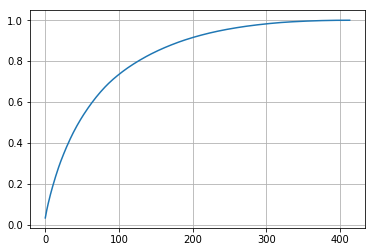

In [58]:
# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.grid()
plt.plot(range(len(cumulative_explained_variance)), cumulative_explained_variance)

This chart is saying: To capture about 98% of the variance, we'd need to keep around 300 components.

We can confirm:

In [60]:

# How much variance we'd capture with the first 125 components
cumulative_explained_variance[300]

0.9824241831916604

Reducing 2574 features down to 300 (about 88% fewer features) while capturing almost 80% of the original variance is certainly not bad!

Initialize and fit another PCA transformation.
* This time, only keep 300 components.
* Generate the principal component features from the fitted instance and name the new matrix PC_items.
* Then, display the shape of PC_items to confirm it only has 300 features.

In [63]:
pca = PCA(n_components=300)

# Fit and transform item_data_scaled
PC_items = pca.fit_transform(item_data_scaled)

# Display shape of PC_items
PC_items.shape

(414, 300)


Next, for convenience, let's put PC_items into a new dataframe.

We'll also name the columns and update its index to be the same as the orginal item_data's index.

In [64]:
# Put PC_items into a dataframe
items_pca = pd.DataFrame(PC_items)

# Name the columns
items_pca.columns = ['PC{}'.format(i + 1) for i in range(PC_items.shape[1])]

# Update its index
items_pca.index = item_data.index

# Display first 5 rows
items_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,...,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347.0,5.876141,4.828917,-0.495545,3.093849,-0.633706,-11.534092,2.161996,7.116957,5.336009,4.424414,4.637002,2.316503,12.310783,1.986696,-11.431269,5.617791,-2.177268,7.665832,-12.135817,-16.049000,-5.949238,7.814288,40.518194,-35.575039,-17.557418,6.869259,20.886868,2.296657,-26.160394,-32.580135,7.880285,12.358371,6.826718,-32.957865,-4.405057,-17.238628,-11.272274,-14.487767,-2.766330,4.736717,-6.985885,-1.464059,10.603071,1.239909,3.086324,5.336237,-0.410775,1.616711,-6.383660,3.065177,...,0.001398,-0.423689,-0.214606,0.025716,0.120643,-0.279154,-0.193583,-0.177826,-0.179399,-0.133529,0.194198,-0.086814,-0.132232,-0.178308,-0.108064,0.097931,0.132934,-0.028067,0.211976,-0.274449,-0.176543,-0.011896,0.101302,-0.057765,0.018925,-0.077115,-0.023432,-0.015672,-0.010804,-0.076371,0.105828,-0.123285,0.195800,-0.049352,-0.033684,0.042549,-0.144525,0.061757,-0.030610,-0.051605,0.038445,0.040457,0.071544,0.020749,0.041273,-0.021032,0.004331,0.038347,-0.090908,-0.070487
12348.0,-4.219837,1.226217,-1.881912,-0.174340,0.817996,1.160834,-0.871683,-0.846634,0.460240,0.854274,-0.401793,0.981803,-1.104237,0.770190,-0.092975,-0.313393,-0.448633,1.207301,0.381678,-0.469152,0.185789,0.054585,0.499987,0.373514,1.226616,-0.773072,-0.270125,0.850015,-0.370482,-0.573939,1.012802,-0.580828,0.949802,-0.733971,0.353890,-0.387479,-0.298542,0.396418,0.154926,0.333479,-0.466262,0.703453,1.200580,-0.202163,-0.871794,-0.055069,-0.421731,-1.623013,-0.397690,0.452591,...,-0.261234,0.990753,-0.298529,-1.027226,1.228258,0.778334,-0.424051,-0.543917,0.840975,-0.294187,1.357993,-1.373942,0.746869,-0.700093,0.214199,1.192861,0.862051,0.001087,-0.235214,0.119163,0.703315,-0.150185,-0.598033,0.750471,-0.705040,-0.487058,1.219670,0.838822,-0.539091,0.178577,-0.272991,-0.082317,-0.214303,0.116075,-0.015861,-0.314688,0.836391,-0.013488,-0.404459,0.828275,-0.133392,-0.388780,0.529042,-0.105000,1.557158,0.187383,-0.469600,-0.964351,-1.086127,0.125669
12349.0,-1.260847,2.387664,-0.073148,-1.119161,-0.034339,-3.715390,-0.343602,-0.149045,-0.790001,-0.379234,1.570090,0.183310,0.223639,-0.051066,3.179090,-0.512679,-1.839577,0.383216,0.317492,-0.003006,-0.420161,0.456437,-0.789675,1.751367,-1.481236,0.757191,-0.912292,0.771947,0.503370,-1.345637,0.286381,0.668565,0.085125,-0.216750,-0.667408,-1.535679,0.783800,-1.418823,-0.098816,-0.929870,0.090829,-0.095243,-0.163216,0.700639,1.381550,-0.243735,-0.105135,-0.176475,0.862919,1.685210,...,0.550989,0.273446,-0.258852,-0.181985,0.838868,-0.646516,0.626151,0.062135,1.169655,-0.496576,0.267786,-0.310169,0.356189,0.324490,-0.074972,-0.157141,-0.386752,0.860416,0.249592,-0.012882,0.086945,-0.207297,0.027710,0.227700,0.234778,-0.049242,0.126961,-0.089367,-0.124899,0.540503,-0.160883,-0.107354,0.310047,-0.129159,-0.465417,0.402151,-0.449746,-0.235542,0.001909,0.056581,0.443521,0.288449,-0.505894,0.338002,0.013855,0.007931,0.542567,0.433875,0.656764,0.463373
12350.0,-4.929320,-0.714859,-1.580930,-0.469767,-0.116290,0.647835,0.112904,-1.336313,1.547069,-1.190409,-0.213170,1.057289,-0.475002,0.856574,-1.305370,0.242700,0.268312,1.952558,-0.227722,0.569825,-0.186512,0.903529,1.364749,0.178125,-0.260397,-0.168826,-0.681953,1.081305,-0.155239,-0.397163,0.240050,0.634067,-1.447081,-0.186098,-0.315379,-0.306430,-1.359020,-0.001473,0.579057,-0.248314,0.588130,-0.217986,0.284602,0.525266,-0.531

* Now we have a dataframe of 300 customer-level principal component features.
* These were generated from the 300 principal components that explained the most variance for the original features.
* The index of this PCA item dataframe contains CustomerID's, which will make it possible for us to join this to our analytical base table.

Finally, save this item dataframe with PCA features as 'pca_item_data.csv'.
* Next, we'll compare the clusters made from using these features against those in 'threshold_item_data.csv'.
* Do not set index=None because we want to keep the CustomerID's as the index.

In [65]:
items_pca.to_csv('Files/pca_item_data.csv')

# 9. KMeans Clustering
Let's import 3 CSV files we've saved throughout this project.
* Let's import 'analytical_base_table.csv' as base_df.
* Let's import 'threshold_item_data.csv' as threshold_item_data.
* Let's import 'pca_item_data.csv' as pca_item_data.
* Set index_col=0 for each one to use CustomerID as the index.

In [67]:
# Import analytical base table
base_df = pd.read_csv('Files/analytical_base_table.csv', index_col=0)

# Import thresholded item features
threshold_item_data = pd.read_csv('Files/threshold_item_data.csv', index_col=0)

# Import PCA item features
pca_item_data = pd.read_csv('Files/pca_item_data.csv', index_col=0)

Because K-Means creates clusters based on distances, and because distances are calculated by between observations defined by their feature values, **the features you choose to input into the algorithm heavily influence the clusters that are created.**

For this project, we will look at 3 possible feature sets and compare the clusters created from them. We'll try:
1. Only purchase pattern features ("Base DF")
2. Purchase pattern features + item features chosen by thresholding ("Threshold DF")
3. Purchase pattern features + principal component features from items ("PCA DF")

Create a threshold_df by joining base_df with threshold_item_data.

In [68]:
# Join base_df with threshold_item_data
threshold_df = base_df.join(threshold_item_data)

# Display first 5 rows of threshold_df
threshold_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,22748,22847,15056BL,23159,85014B,23243,23231,22898,23388,23255,22966,22558,21558,22356,84997C,23292,22699,22331,22385,23480,84375,21156,21242,22417,21122,84997B,22895,22962,22557,22907,23307,20676,21977,21976,23293,22661,23290,22627,84879,20682,22367,23236,...,22631,22090,23199,21915,23203,84997D,22029,23209,23254,22077,22960,23256,22492,22467,22726,22382,23240,23245,21094,21086,23206,22352,22727,22138,22720,21559,22728,22555,20724,20712,22961,22630,22139,21080,85099B,20726,20719,20750,23084,20725,21212,22551,22629,22328,21731,22556,22554,22423,22326,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347.0,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,1,0,0,0,2,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,5,0,0,0,3,0,0,0,0,0,0,0,0,0,4,0,3,0,0,0,0,0,5,0,0,4,0,0
12348.0,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
12349.0,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
12350.0,1,17,17,334.40,19.670588,334.400000,334.40,334.40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
12352.0,8,85,59,2506.04,29.482824,313.255000,120.33,840.30,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,5


In [69]:
# Join base_df with pca_item_data
pca_df = base_df.join(pca_item_data)

# Display first 5 rows of pca_df
pca_df.head()

,total_transactions,total_products,total_unique_products,total_sales,avg_product_value,avg_cart_value,min_cart_value,max_cart_value,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,...,PC251,PC252,PC253,PC254,PC255,PC256,PC257,PC258,PC259,PC260,PC261,PC262,PC263,PC264,PC265,PC266,PC267,PC268,PC269,PC270,PC271,PC272,PC273,PC274,PC275,PC276,PC277,PC278,PC279,PC280,PC281,PC282,PC283,PC284,PC285,PC286,PC287,PC288,PC289,PC290,PC291,PC292,PC293,PC294,PC295,PC296,PC297,PC298,PC299,PC300
CustomerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12347.0,7,182,103,4310.00,23.681319,615.714286,224.82,1294.32,5.876141,4.828917,-0.495545,3.093849,-0.633706,-11.534092,2.161996,7.116957,5.336009,4.424414,4.637002,2.316503,12.310783,1.986696,-11.431269,5.617791,-2.177268,7.665832,-12.135817,-16.049000,-5.949238,7.814288,40.518194,-35.575039,-17.557418,6.869259,20.886868,2.296657,-26.160394,-32.580135,7.880285,12.358371,6.826718,-32.957865,-4.405057,-17.238628,-11.272274,-14.487767,-2.766330,4.736717,-6.985885,-1.464059,...,0.001398,-0.423689,-0.214606,0.025716,0.120643,-0.279154,-0.193583,-0.177826,-0.179399,-0.133529,0.194198,-0.086814,-0.132232,-0.178308,-0.108064,0.097931,0.132934,-0.028067,0.211976,-0.274449,-0.176543,-0.011896,0.101302,-0.057765,0.018925,-0.077115,-0.023432,-0.015672,-0.010804,-0.076371,0.105828,-0.123285,0.195800,-0.049352,-0.033684,0.042549,-0.144525,0.061757,-0.030610,-0.051605,0.038445,0.040457,0.071544,0.020749,0.041273,-0.021032,0.004331,0.038347,-0.090908,-0.070487
12348.0,4,31,22,1797.24,57.975484,449.310000,227.44,892.80,-4.219837,1.226217,-1.881912,-0.174340,0.817996,1.160834,-0.871683,-0.846634,0.460240,0.854274,-0.401793,0.981803,-1.104237,0.770190,-0.092975,-0.313393,-0.448633,1.207301,0.381678,-0.469152,0.185789,0.054585,0.499987,0.373514,1.226616,-0.773072,-0.270125,0.850015,-0.370482,-0.573939,1.012802,-0.580828,0.949802,-0.733971,0.353890,-0.387479,-0.298542,0.396418,0.154926,0.333479,-0.466262,0.703453,...,-0.261234,0.990753,-0.298529,-1.027226,1.228258,0.778334,-0.424051,-0.543917,0.840975,-0.294187,1.357993,-1.373942,0.746869,-0.700093,0.214199,1.192861,0.862051,0.001087,-0.235214,0.119163,0.703315,-0.150185,-0.598033,0.750471,-0.705040,-0.487058,1.219670,0.838822,-0.539091,0.178577,-0.272991,-0.082317,-0.214303,0.116075,-0.015861,-0.314688,0.836391,-0.013488,-0.404459,0.828275,-0.133392,-0.388780,0.529042,-0.105000,1.557158,0.187383,-0.469600,-0.964351,-1.086127,0.125669
12349.0,1,73,73,1757.55,24.076027,1757.550000,1757.55,1757.55,-1.260847,2.387664,-0.073148,-1.119161,-0.034339,-3.715390,-0.343602,-0.149045,-0.790001,-0.379234,1.570090,0.183310,0.223639,-0.051066,3.179090,-0.512679,-1.839577,0.383216,0.317492,-0.003006,-0.420161,0.456437,-0.789675,1.751367,-1.481236,0.757191,-0.912292,0.771947,0.503370,-1.345637,0.286381,0.668565,0.085125,-0.216750,-0.667408,-1.535679,0.783800,-1.418823,-0.098816,-0.929870,0.090829,-0.095243,...,0.550989,0.273446,-0.258852,-0.181985,0.838868,-0.646516,0.626151,0.062135,1.169655,-0.496576,0.267786,-0.310169,0.356189,0.324490,-0.074972,-0.157141,-0.386752,0.860416,0.249592,-0.012882,0.086945,-0.207297,0.027710,0.227700,0.234778,-0.049242,0.126961,-0.089367,-0.124899,0.540503,-0.160883,-0.107354,0.310047,-0.129159,-0.465417,0.402151,-0.449746,-0.235542,0.001909,0.056581,0.443521,0.288449,-0.505894,0.338002,0.013855,0.007931,0.542567,0.433875,0.656764,0.463373
12350.0,1,17,17,334.40,19.670588,334.400000,334.40,334.40,-4.929320,-0.714859,-1.580930,-0.469767,-0.116290,0.647835,0.112904,-1.336313,1.547069,-1.190409,-0.213170,1.057289,-0.475002,0.856574,-1.305370,0.242700,0.268312,1.952558,-0.227722,0.569825,-0.186512,0.903529,1.364749,0.178125,-0.260397,-0.168826,-0.681953,1.081305,-0.155239,-0.397163,0.240050,0.634067,-1.447081,-0.186098,-0.315379,-0.306430,-1.359020,-

Let us scale the data

In [70]:
# Initialize instance of StandardScaler
t_scaler = StandardScaler()
p_scaler = StandardScaler()

# Fit and transform
threshold_df_scaled = t_scaler.fit_transform(threshold_df)
pca_df_scaled = p_scaler.fit_transform(pca_df)

K-Means with threshold_df

In [71]:
t_kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 123)

In [72]:
t_kmeans.fit(threshold_df_scaled)
threshold_df['cluster'] = t_kmeans.fit_predict(threshold_df_scaled)

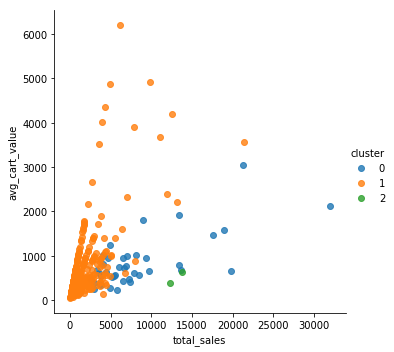

In [73]:
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=threshold_df, fit_reg=False)

K-Means with pca_df

In [74]:
p_kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 123)

In [75]:

p_kmeans.fit(pca_df_scaled)
pca_df['cluster'] = p_kmeans.fit_predict(pca_df_scaled)

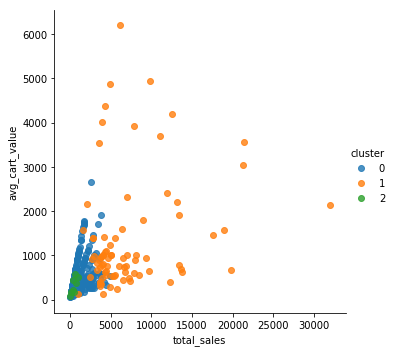

In [76]:
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=pca_df, fit_reg=False)

In [77]:
# Similary between base_df.cluster and threshold_df.cluster
adjusted_rand_score(pca_df.cluster, threshold_df.cluster)

0.4161850842655694